In [1]:
import json
import yaml
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))
from sklearn.metrics import f1_score
import re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

######## gpt-4-1106-preview ########
task_0_new_udfs_mean_f1: 0.9063891363051549

task_1_new_udfs_mean_f1: 0.5420834469113944

task_2_new_udfs_mean_f1: 0.3742045100557927

task_3_new_udfs_mean_f1: 0.19746966265686347

######## gpt-3.5-turbo-1106 ########
task_0_new_udfs_mean_f1: 0.8144534066211149

task_1_new_udfs_mean_f1: 0.08400186171752422

task_2_new_udfs_mean_f1: 0.00785347810523804

task_3_new_udfs_mean_f1: 0.0

######## gpt-3.5-turbo-instruct ########
task_0_new_udfs_mean_f1: 0.7632531159529745

task_1_new_udfs_mean_f1: 0.033094555873925506

task_2_new_udfs_mean_f1: 0.0

task_3_new_udfs_mean_f1: 0.0

######## llava_clevr/without_ccot ########
task_0_new_udfs_mean_f1: 0.3399468559549693

task_1_new_udfs_mean_f1: 0.3399468559549693

task_2_new_udfs_mean_f1: 0.3399468559549693

task_3_new_udfs_mean_f1: 0.3399468559549693

######## pred_all_pos ########
task_0_new_udfs_mean_f1: 0.2766842144016708

task_1_new_udfs_mean_f1: 0.2766842144016708

task_2_new_udfs_mean_f1: 0.27668421440167

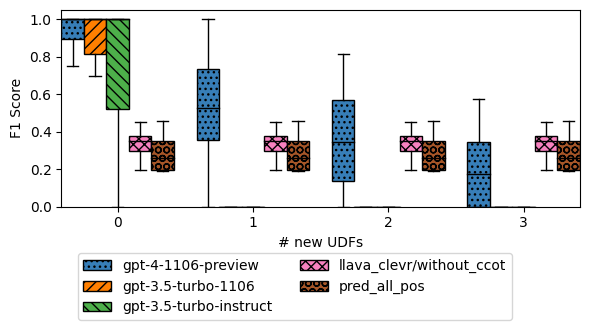

In [2]:
# Define LLM models, tasks, number of new UDFs, and hatch patterns
llm_models = ['gpt-4-1106-preview', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-instruct',
              'llava_clevr/without_ccot',
#               'llava_clevr/with_ccot',
              'pred_all_pos'
             ]
tasks = [f"{i}_new_udfs" for i in range(4)]
num_new_udfs = [0, 1, 2, 3]
hatch_patterns = ['...', '///', '\\\\\\', 'xxx', 'OO', '|||', '+++']
handles_f1 = []

# Create a figure and axis for the boxplot
fig, ax = plt.subplots(1, 1, figsize=(6, 2.7))  # Adjust the figsize as needed

# Iterate through LLM models
for i, llm_model in enumerate(llm_models):
    print(f"######## {llm_model} ########")
    f1_data = []

    # Iterate through tasks
    for task in tasks:
        accuracy_list = []
        f1_list = []
        precision_list = []
        recall_list = []
        failed_list = []

        # Iterate through runs and questions
        for run_id in range(5):
            for question_id in range(10):
                try:
                    if llm_model in ["pred_all_pos"]:
                        with open(os.path.join(config['output_dir'], "clevr", "gpt-3.5-turbo-1106", f"task_{task}_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
                            data = json.load(f)
                            gt_positive_images = data['gt_positive_images']
                            gt_labels = []
                            for fid in range(15000):
                                if fid in gt_positive_images:
                                    gt_labels.append(1)
                                else:
                                    gt_labels.append(0)
                            pred_labels = [1] * 15000
                            f1 = f1_score(gt_labels, pred_labels)
                            data["f1"] = f1
                    elif llm_model in ['llava_clevr/without_ccot', 'llava_clevr/with_ccot']:
                        with open(os.path.join(config['output_dir'], llm_model, f"task_3_new_udfs_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
                            data = json.load(f)
                            failed_list.append(0)
                    else:
                        with open(os.path.join(config['output_dir'], "clevr", llm_model, f"task_{task}_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
                            data = json.load(f)
                            failed_list.append(data["failed"])
                    # accuracy_list.append(data["accuracy"])
                    f1_list.append(data["f1"])
                    # precision_list.append(data["precision"])
                    # recall_list.append(data["recall"])
                except Exception as e:
                    print(e)
                    continue

        f1_data.append(f1_list)
        # print(f"task_{task}_mean_accuracy: {np.mean(accuracy_list)}")
        print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
        # print(f"task_{task}_mean_precision: {np.mean(precision_list)}")
        # print(f"task_{task}_mean_recall: {np.mean(recall_list)}")
        # print(f"task_{task}_prob_failures: {np.mean(failed_list)}")
        print()

    # Create a grouped boxplot for F1 scores
    bp_f1 = ax.boxplot(f1_data,
                       positions=np.array(range(len(f1_data))) * (len(llm_models) + 1) + i,
                       sym='.',
                       widths=1,
                       showfliers=False,
                       patch_artist=True,
                       boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                       medianprops=dict(color='black'))
    handles_f1.append(bp_f1["boxes"][0])

# Customize the plot labels and legend
ax.set(ylabel="F1 Score")
ax.set(xlabel="# new UDFs")
ax.set_ylim(bottom=0, top=1.05)
ax.set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 0.5, len(llm_models) + 1))
ax.set_xticklabels(num_new_udfs)
fig.legend(handles_f1, llm_models, prop={"size": 10}, loc='upper center', bbox_to_anchor=(0.5, 0.07),
           fancybox=True, shadow=False, ncol=2)
plt.subplots_adjust(bottom=0.15)
fig.tight_layout()
plt.show()